In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import heatmap_setup as hm
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


In [2]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'

In [3]:
def dark_bright_displacements(PARAMS):
    disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']**2+4*PARAMS['V']**2)
    coeff_m = (eta-PARAMS['bias'])/(2*eta)
    coeff_p = (eta+PARAMS['bias'])/(2*eta)
    
    # dark 1&2, bright 1&2
    return [disp_1*coeff_m, disp_2*coeff_p], [disp_1*coeff_p, disp_2*coeff_m]


def polaron_eigenstates(PARAMS_):
    disp_1 = sqrt(pi*PARAMS_['alpha_1']/(2*PARAMS_['w0_1']))
    kappa_1 =  np.sqrt(np.pi * PARAMS_['alpha_1'] * PARAMS_['w0_1'] / 2.)
    disp_2 = sqrt(pi*PARAMS_['alpha_2']/(2*PARAMS_['w0_2']))
    kappa_2 =  np.sqrt(np.pi * PARAMS_['alpha_2'] * PARAMS_['w0_2'] / 2.)
    B1 = np.exp(-(disp_1**2)/2)  # Coth(beta_f(PARAMS['T_1'])*PARAMS['w0_1']/2)*
    B2 = np.exp(-(disp_2**2)/2) # Coth(beta_f(PARAMS['T_2'])*PARAMS['w0_2']/2)*
    #B1, B2 = coherent_overlaps_plain(PARAMS)
    
    w_1, w_2 = PARAMS_['w_1'], PARAMS_['w_1']
    shift_1, shift_2 = 0,0 #pi*PARAMS['alpha_1']/2, pi*PARAMS['alpha_2']/2
    V = PARAMS_['V']
    bias = PARAMS_['bias'] + shift_1 - shift_2
    eta = sqrt(PARAMS_['bias']**2+4*PARAMS_['V']**2)
    av_site_energy = (w_1+shift_1+w_2+shift_2)/2
    
    eta_polaron = sqrt(PARAMS_['bias']**2+4*B1*B2*(PARAMS_['V']**2))
    disp_dark, disp_bright = dark_bright_displacements(PARAMS_)
    second_order = ((2*V*bias*B1*B2/eta)**2)/eta
    print(second_order)
    dark_energy = av_site_energy - (eta_polaron**2)/(2*eta) - second_order
    #dark_energy += PARAMS['w0_1']*(disp_dark[0]**2)+PARAMS['w0_2']*(disp_dark[1]**2)
    
    bright_energy = av_site_energy + (eta_polaron**2)/(2*eta) + second_order
    #bright_energy += PARAMS['w0_1']*(disp_bright[0]**2)+(PARAMS['w0_2']**2)*(disp_bright[1]**2)
    eta_P = (eta_polaron**2)/eta
    v_p = qt.Qobj(np.array([0., np.sqrt(eta_P+bias), np.sqrt(eta_P-bias)]))/np.sqrt(2*eta_P)
    v_m = qt.Qobj(np.array([0., np.sqrt(eta_P-bias), -np.sqrt(eta_P+bias)]))/np.sqrt(2*eta_P)
    
    return [dark_energy, bright_energy], [v_m, v_p], eta_polaron

In [4]:
def calculate_coherence_4_theories(PARAMS, num, threshold=0.):
    phonons = np.linspace(0.5, 20e-3*ev_to_inv_cm, 25)
    
    ti =time.time()
    rho_add = []
    rho_nonadd = []
    rho_sec = []
    rho_wc = []
    
    op_list = []
    
    for j, alpha in enumerate(phonons):
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        #energies, states = exciton_states(PARAMS)
        H, L, PARAMS = get_H_and_L_add_and_sec(PARAMS,silent=True, threshold=0.)
        H_wc, L_ns, L_s = get_H_and_L_wc(H[0], PARAMS)
        rho_add.append(steadystate(H[1], [L['add']]))
        rho_nonadd.append(steadystate(H[1], [L['nonadd']]))
        rho_sec.append(steadystate(H[1], [L['sec']]))
        rho_wc.append(steadystate(H[0], [L_ns])) # shift in wc LVN
        op_list.append(make_expectation_operators(PARAMS))
        if j in [1,10,20,30,40,49]:
            print(alpha)
        #print ss.diag()
    data_dict = {}
    filename = 'DATA/coherence/four_theories_{}'.format(num)
    PARAM_names = ['rho_nonadd', 'rho_add', 'rho_sec',
                   'rho_wc', 'op_list', 'phonons', 'PARAMS']
    scope = locals() # Lets eval below use local variables, not global
    data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
    print("Calculation took {} seconds".format(time.time()-ti))
    try:
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print("Could not save file because: {}".format(e))
    return data_dict


def calculate_bias_dependence(PARAMS, num, threshold=0.):
    phonons = np.array([6,12,18])*1e-3*ev_to_inv_cm
    biases = np.linspace(0., 30e-3*ev_to_inv_cm, 3)
    ti =time.time()
    rho_add_list = []
    rho_nonadd_list = []
    op_list = []
    
    for alpha in phonons:
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        rho_nonadd = []
        opss = []
        for j, bias in enumerate(biases):
            #PARAMS = get_converged_N(PARAMS, err_threshold=5., min_N=3,max_N=11, silent=True, exc_diff_N=False)
            PARAMS = PARAMS_update_bias(PARAMS_init=PARAMS, bias_value=bias)
            
            H, L, PARAMS = get_H_and_L_full(PARAMS,silent=True, threshold=0.)
            rho_nonadd.append(steadystate(H[1], [L['nonadd']]))
            
            opss.append(make_expectation_operators(PARAMS))
            if j in [1,10,20,30,40,49]:
                print(alpha)
            #print ss.diag()
        rho_nonadd_list.append(rho_nonadd)
        op_list.append(opss)
    data_dict = {}
    filename = 'DATA/coherence/bias_{}'.format(num)
    PARAM_names = ['rho_nonadd_list', 'rho_add_list', 'biases',
                    'op_list', 'phonons', 'PARAMS']
    scope = locals() # Lets eval below use local variables, not global
    data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
    print("Calculation took {} seconds".format(time.time()-ti))
    try:
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print("Could not save file because: {}".format(e))
    return data_dict


In [5]:
def polaron_coherence(PARAMS):
    energies, states, eta = polaron_eigenstates(PARAMS)
    return states[0]*states[1].dag()

def calculate_polaron_coherence(rho_list, phonons, PARAMS, wc=False):
    pol_coh = []
    for alpha, rho in zip( phonons, rho_list):
        PARAMS.update({'alpha_1' : alpha, 'alpha_2' : alpha})
        I = enr_identity([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
        if wc:
            polaron_coherence_op = polaron_coherence(PARAMS)
        else:
            polaron_coherence_op = tensor(polaron_coherence(PARAMS), I)
        pol_coh.append((polaron_coherence_op*rho).tr())
    return np.array(pol_coh)

def calculate_expval(rho_list, op_list, obs='OO'):
    return np.array([(op_list[i][obs]*rho).tr() for i, rho in enumerate(rho_list)])

28.7158552164149
26.902048593863167
25.202809148197478
23.610900364865216
22.119542816101674
20.722385289526333
19.4134777403712
18.18724595215278
17.038467797876013
15.962251000674174
14.954012299174329
14.009457928860545
13.124565336311129
12.295566048436669
11.518929623764626
10.791348617423976
10.10972449580077
9.471154440879511
8.872918988074417
8.31247044490393
7.787422041187452
7.295537764558384
6.834722838006311
6.403014798895051
5.9985751414651824
28.7158552164149
26.902048593863167
25.202809148197478
23.610900364865216
22.119542816101674
20.722385289526333
19.4134777403712
18.18724595215278
17.038467797876013
15.962251000674174
14.954012299174329
14.009457928860545
13.124565336311129
12.295566048436669
11.518929623764626
10.791348617423976
10.10972449580077
9.471154440879511
8.872918988074417
8.31247044490393
7.787422041187452
7.295537764558384
6.834722838006311
6.403014798895051
5.9985751414651824
28.7158552164149
26.902048593863167
25.202809148197478
23.610900364865216
22.1

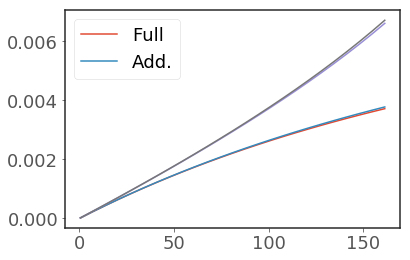

In [10]:
def plot_all_four_theories(data_dict):
    phonons = data_dict['phonons']
    wc_ops = [make_expectation_operators(data_dict['PARAMS'], 
                                         weak_coupling=True)]*len(data_dict['phonons'])
    
    plt.plot(phonons, np.abs(calculate_expval(data_dict['rho_nonadd'], 
                                                           data_dict['op_list'], 
                                                           obs='eig_x')), label="Full")
    plt.plot(phonons, np.abs(calculate_expval(data_dict['rho_add'], 
                                                           data_dict['op_list'], 
                                                           obs='eig_x')), label="Add.")
    #plt.plot(phonons, np.abs(calculate_expval(data_dict['rho_sec'], 
    #                                                       data_dict['op_list'], 
    #                                                       obs='eig_x')), label="Sec.")
    #plt.plot(data_dict['phonons'], np.abs(calculate_expval(data_dict['rho_wc'], 
    #                                                       wc_ops, 
    #                                                       obs='eig_x')), label="WC")
    plt.legend()
    #plt.figure()
    pc1 = calculate_polaron_coherence(data_dict['rho_nonadd'], phonons, data_dict['PARAMS'])
    plt.plot(phonons, np.abs(calculate_polaron_coherence(data_dict['rho_nonadd'], 
                                                           phonons, data_dict['PARAMS'])), label="Full")
    plt.plot(phonons, np.abs(calculate_polaron_coherence(data_dict['rho_add'], 
                                                           phonons, data_dict['PARAMS'])), label="Add.")
    
    #plt.plot(phonons, np.abs(calculate_polaron_coherence(data_dict['rho_sec'], 
    #                                                       phonons, PARAMS)), label="Sec.")
    #plt.plot(phonons, np.abs(calculate_polaron_coherence(data_dict['rho_wc'], 
    #                                                       phonons, PARAMS, wc=True)), label="Sec.")
plot_all_four_theories(dd_4th2)

In [23]:
N=7
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 10*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
Gamma = 100
w0 = 40e-3*ev_to_inv_cm
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                  V = V, alpha=alpha,
                  T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                  num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                  silent=True, exc_diff=0)




In [24]:
dd_4th = calculate_coherence_4_theories(PARAMS, 1, threshold=1e-8)

It took  269.32801032066345  seconds to build the secular RWA Liouvillian
It took  315.05917596817017  seconds to build the secular RWA Liouvillian
7.2004166666666665
It took  323.66229486465454  seconds to build the secular RWA Liouvillian
It took  316.6928069591522  seconds to build the secular RWA Liouvillian
It took  326.07050108909607  seconds to build the secular RWA Liouvillian
It took  321.6380729675293  seconds to build the secular RWA Liouvillian
It took  325.2177219390869  seconds to build the secular RWA Liouvillian
It took  328.60890531539917  seconds to build the secular RWA Liouvillian
It took  326.6497390270233  seconds to build the secular RWA Liouvillian
It took  323.82911586761475  seconds to build the secular RWA Liouvillian
It took  314.30792593955994  seconds to build the secular RWA Liouvillian
67.50416666666666
It took  315.619735956192  seconds to build the secular RWA Liouvillian
It took  314.13721442222595  seconds to build the secular RWA Liouvillian
It took

28.7158552164149
26.902048593863167
25.202809148197478
23.610900364865216
22.119542816101674
20.722385289526333
19.4134777403712
18.18724595215278
17.038467797876013
15.962251000674174
14.954012299174329
14.009457928860545
13.124565336311129
12.295566048436669
11.518929623764626
10.791348617423976
10.10972449580077
9.471154440879511
8.872918988074417
8.31247044490393
7.787422041187452
7.295537764558384
6.834722838006311
6.403014798895051
5.9985751414651824
28.7158552164149
26.902048593863167
25.202809148197478
23.610900364865216
22.119542816101674
20.722385289526333
19.4134777403712
18.18724595215278
17.038467797876013
15.962251000674174
14.954012299174329
14.009457928860545
13.124565336311129
12.295566048436669
11.518929623764626
10.791348617423976
10.10972449580077
9.471154440879511
8.872918988074417
8.31247044490393
7.787422041187452
7.295537764558384
6.834722838006311
6.403014798895051
5.9985751414651824
28.7158552164149
26.902048593863167
25.202809148197478
23.610900364865216
22.1

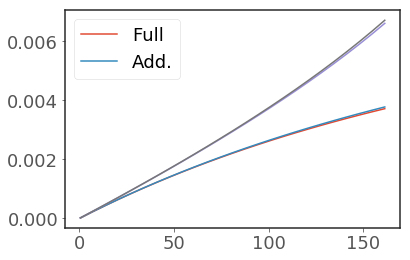

In [38]:
plot_all_four_theories(dd_4th2)

In [7]:
dd_4th2 =  load_obj("DATA/coherence/four_theories_1")

In [8]:
dd_bd = calculate_bias_dependence(PARAMS, 1, threshold=0.)

48.393
96.786
145.17900000000003
Calculation took 23.76140809059143 seconds
Filename: DATA/coherence/bias_1


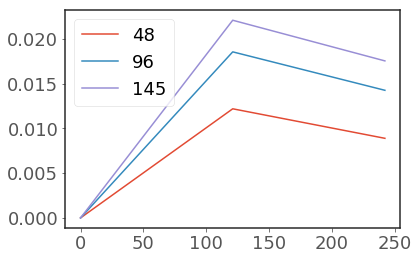

In [9]:
def plot_bias_dependence(data_dict):
    biases = data_dict['biases']
    phonons = data_dict['phonons']
    i = 0
    for oplist, rho_list in zip(data_dict['op_list'], data_dict['rho_nonadd_list']):
        plt.plot(biases, np.abs(calculate_expval(rho_list, oplist,obs='eig_x')), label=str(int(phonons[i])))
        i+=1
    plt.legend()
plot_bias_dependence(dd_bd)